## Setup

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 14,6
import seaborn as sns
colors = sns.color_palette('pastel')[0:5]
sns.set_style('whitegrid')
sns.set_palette("colorblind")

import scikitplot as skplt

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from warnings import filterwarnings
filterwarnings('ignore')

In [ ]:
!ls dataset

In [2]:
# Read the dataset
df = pd.read_csv('dataset/credit_risk_dataset.csv', sep=',')
df.head(3)

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3


**Data Catalog**  

**Feature Name** || **Description**  
person_ag || Age  
person_income || Annual Income  
person_home_ownership || Home ownership  
person_emp_length || Imployment length (in years)  
loan_intent || Loan intent  
loan_grade || Loan grade  
loan_amnt || Loan amount  
loan_int_rate || Interest rate  
loan_status || Loan status (0 is non default 1 is default)  
loan_percent_income || Percent income  
cb_person_default_on_file || Historical default  
cb_preson_cred_hist_length || Credit history length  

## Data Exploration

Objective: Found caracteristics that define a risk and create a risk profile. 

In [ ]:
df.info()

In [ ]:
df.isnull().sum()

Two columns with null values.   
We need to further define how treat these values.

In [ ]:
df.head(3)

In [ ]:
# create two lists; Object columns and Numeric columns

list_obj = df.select_dtypes(include='object').columns.tolist()
list_numeric = df.select_dtypes(include='number').columns.tolist()
list_numeric.remove('loan_status')


list_obj, list_numeric

In [ ]:
# Target distribuations
plt.pie(df['loan_status'].value_counts(normalize=True), autopct='%.2f%%', colors=colors)
plt.legend(df['loan_status'].value_counts().index)
plt.title('Target Distribuations')
plt.show()

We noticed that the dataset is unbalanced, with only 21.8% of risk profiles.

In [ ]:
# Categoric distribuations with target
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, col in enumerate(list_obj):
    cross_table = pd.crosstab(df[col], df['loan_status'], normalize='index') * 100
    cross_table.plot(kind='barh', stacked=True, color=['skyblue', 'salmon'], ax=axes[i])
    axes[i].set_title(f'{col} with Target')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')

    for container in axes[i].containers:
            axes[i].bar_label(container, fmt='%.1f%%', label_type='center')
    
plt.tight_layout()
plt.show()

The graphs above shows percentage of risk in different categorical variables.  

The "loan_grade with target"-graph shows a big difference when we have loan_grade equal G, F, E and D. In short, the higher the loan grade in alphabetical order, the greater the probability of risk.

In [ ]:
# Analylising loan grade with target, applying the proportions_ztest
from statsmodels.stats.proportion import proportions_ztest

risk_group = df[df['loan_grade'].isin(['D','E','F','G'])]
others_group = df[~df['loan_grade'].isin(['D','E','F','G'])]

count_risk = risk_group['loan_status'].sum()
count_others = others_group['loan_status'].sum()

total_risk = risk_group.shape[0]
total_others = others_group.shape[0]

# Proportion test
counts = [count_risk, count_others]
n = [total_risk, total_others]

stat, p_value = proportions_ztest(counts, n, alternative='larger')

print(f'Statics Z: {stat:.4f}')
print(f'Value-p: {p_value:.4f}')

The Value-p equal 0 shows that the hypothesis that if individual has a grade equal D,E,F,G there is a higher probability of being a risk is true.

In [ ]:
# Only Density analysis
plt.figure(figsize=(14,10))

list_numeric = df.select_dtypes(include='number').columns.tolist()
list_numeric_without_target = df.select_dtypes(include='number').columns.tolist()
list_numeric_without_target.remove('loan_status')

for i, var in enumerate(list_numeric_without_target):
    plt.subplot(3, 3, i+1)
    sns.kdeplot(data=df[list_numeric], x=var, hue='loan_status', fill=True, common_norm=False, alpha=0.5)
    plt.title(f'{var} vs target')
    plt.grid()
    
plt.tight_layout()
plt.show()

The density graphs showed similarity, but, the graphs 'loan_int_rate vs target' and 'loan_percent_income vs target' showed a dustinction from large values.

In [ ]:
# Correlations analysis
sns.heatmap(df[list_numeric].corr(), annot=True)
plt.title('Correlation Analysis')
plt.show()

Looking at the target column as an independent variable, we see a strong correlation with columns loan_int_rate (interest rate) and loan_percent_income (Percent income).  

We can also see a strong correlation between the person age and credit history length columns. 

In [ ]:
# We will plot the correlation the loan_int_rate and loan_status

sns.scatterplot(data=df, x=df.loan_int_rate, y=df.loan_percent_income, hue=df.loan_status)
plt.title('Loan Percent vs Interest Rate')
plt.show()

Resume:  
Note that the risk profiles have a 2 characteristics;  
1 - loan_grade = D,E,F,G;  
2 - loan_int_rate and loan_percent in relation to the target, where the higher values tend towards risk.


These characteristics can help the model to classify correctly. 

In [ ]:
df.head(3)

In [ ]:
# Plus - Using the decision tree for segmentations the risk class
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

df_tree = df.copy()

labelencoder = LabelEncoder()

for col in list_obj:
    df_tree[col] = labelencoder.fit_transform(df_tree[col])

X = df_tree.drop('loan_status', axis=1).values
y = df_tree['loan_status'].values

model_tree = DecisionTreeClassifier(max_depth=3, max_leaf_nodes=3, random_state=42)

model_tree.fit(X, y)

plot_tree(model_tree, class_names= df.columns)
plt.show()

## Modeling

To model the classification model, we will use the pipeline (sklearn), with steps describe below.
- MinMaxScaler: Normalization numeric variables between 0 and 1;
- OneHotEncoder: Transformations categorical variables to numeric variables;
- StratifiedKFold;
- Log Loss Avaliation;
- Select the best model;
- Applying the GridSearch;

In [3]:
# Load_dataset
df = pd.read_csv('dataset/credit_risk_dataset.csv', sep=',')

# Selection cat columns and numeric columns
list_obj = df.select_dtypes(include='object').columns.tolist()
list_numeric = df.select_dtypes(include='number').columns.tolist()
list_numeric.remove('loan_status')

# X e y
X = df.drop('loan_status', axis=1)
y = df['loan_status']

# Dvision train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# MinMaxScaler, OneHotEncoder e SimpleImputer
preprocessor = ColumnTransformer(
    transformers=[
        # Inputation for numeric columns
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')), 
            ('scaler', MinMaxScaler())
        ]), list_numeric),
        
        # Inputation for categoric columns
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), list_obj)
    ]
)

pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor)
    ]
)

# Applying transformations
X_train_transf = pipeline.fit_transform(X_train)
X_test_transf = pipeline.transform(X_test)

# Models
models = {
    'LogisticRegression': LogisticRegression(),
    'DecisionTree': DecisionTreeClassifier(criterion='log_loss'),
    'RandomForest': RandomForestClassifier()
}

# StratifiedKFold
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

# Metrics
result_loss = []
result_models = []

# Processing
for model_name, model in models.items():
    print(f'Model: {model_name}')
    model_loss = []

    for i, (train_index, valid_index) in enumerate(skf.split(X_train_transf, y_train)):
        X_train_fold, X_valid_fold = X_train_transf[train_index], X_train_transf[valid_index]
        y_train_fold, y_valid_fold = y_train.iloc[train_index], y_train.iloc[valid_index]

        # Fit the models
        model.fit(X_train_fold, y_train_fold)

        # Evaluations results
        y_valid_proba = model.predict_proba(X_valid_fold)
        loss = metrics.log_loss(y_valid_fold, y_valid_proba)
        model_loss.append(loss)

        # Display results
        print(f'Fold {i+1} | Log Loss {loss}')

    mean_loss = np.mean(model_loss)
    result_loss.append(model_loss)
    result_models.append((model_name, model_loss))

    print(f'Mean Loss for Model {model_name} is {mean_loss}')
    print('----' * 30)

Model: LogisticRegression
Fold 1 | Log Loss 0.34679985303727906
Fold 2 | Log Loss 0.3348629309856076
Fold 3 | Log Loss 0.33738767751154375
Fold 4 | Log Loss 0.3476582866825476
Fold 5 | Log Loss 0.344976237615669
Mean Loss for Model LogisticRegression is 0.3423369971665293
------------------------------------------------------------------------------------------------------------------------
Model: DecisionTree
Fold 1 | Log Loss 4.258555277670791
Fold 2 | Log Loss 3.9275807354508276
Fold 3 | Log Loss 3.8248472353283707
Fold 4 | Log Loss 4.196268351155713
Fold 5 | Log Loss 3.9828987739783046
Mean Loss for Model DecisionTree is 4.038030074716802
------------------------------------------------------------------------------------------------------------------------
Model: RandomForest
Fold 1 | Log Loss 0.23864816115935686
Fold 2 | Log Loss 0.23676537854255073
Fold 3 | Log Loss 0.25388784251744356
Fold 4 | Log Loss 0.27474618012804297
Fold 5 | Log Loss 0.24265075648279913
Mean Loss for Mode

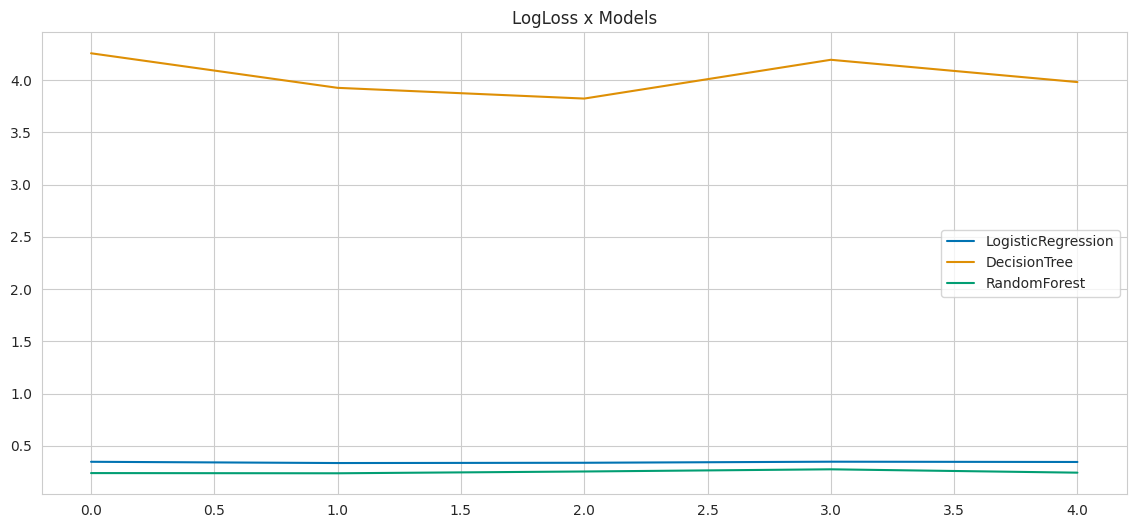

In [4]:
# Plot results
data_dict = {'CV': list(range(1, 6))}

for model, values in result_models:
    data_dict[model] = values

results_df = pd.DataFrame(data_dict)

plt.plot(results_df[['LogisticRegression','DecisionTree', 'RandomForest']])
plt.legend(['LogisticRegression','DecisionTree', 'RandomForest'])
plt.title('LogLoss x Models')
plt.show()

In [5]:
%%time
# The best models = RandomForest
# GridSearch
model_grid = RandomForestClassifier()

params = {
    'n_estimators':[100,250,500],
    'max_depth':[3,5,7],
    'min_samples_split':[2,4,6],
    'min_samples_leaf':[1,3,5]
}

grid = GridSearchCV(model_grid, params, n_jobs=-1, cv=5, scoring='neg_log_loss', verbose=True)
grid.fit(X_train_transf, y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
CPU times: user 2.37 s, sys: 602 ms, total: 2.97 s
Wall time: 2min 54s


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7], 'min_samples_leaf': [1, 3, 5],
                         'min_samples_split': [2, 4, 6],
                         'n_estimators': [100, 250, 500]},
             scoring='neg_log_loss', verbose=True)

In [6]:
# Selection the best params
# Display the best params
print(f'The best params {grid.best_params_}')

# Model
best_params_model = grid.best_estimator_

The best params {'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 100}


<Axes: title={'center': 'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

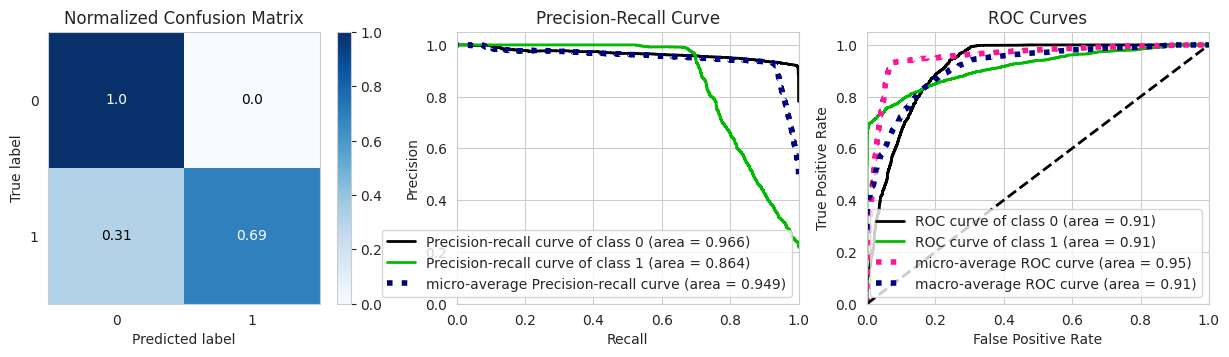

In [11]:
# Evaluation the final model
y_predict_proba = best_params_model.predict_proba(X_test_transf)
y_predict = best_params_model.predict(X_test_transf)

plt.figure(figsize=(15,12))

plt.subplot(3,3,1)
skplt.metrics.plot_confusion_matrix(y_test, y_predict, normalize=True, ax=plt.gca())

plt.subplot(3,3,2)
skplt.metrics.plot_precision_recall(y_test, y_predict_proba, ax=plt.gca())

plt.subplot(3,3,3)
skplt.metrics.plot_roc(y_test, y_predict_proba, ax=plt.gca())